In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [106]:
project_dir = './drive/MyDrive/Tube/data/VG/org'

image_file = json.load(open(f'{project_dir}/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/VG-SGG-dicts-with-attri.json'))
idx2label = vocab_file['idx_to_label']
idx2pred = vocab_file['idx_to_predicate']
data_file = h5py.File(f'{project_dir}/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [24]:
# load detected results
data_dir = './drive/MyDrive/Tube/data/video'

detected_info = json.load(open(f'{data_dir}/custom_data_info.json'))
detected_result = json.load(open(f"{data_dir}/custom_prediction.json"))

In [215]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), idx2label[str(info)])

def draw_single_rel(pic, box_sbj, box_obj, color='blue', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x11,y11,x12,y12 = int(box_sbj[0]), int(box_sbj[1]), int(box_sbj[2]), int(box_sbj[3])
    x21,y21,x22,y22 = int(box_obj[0]), int(box_obj[1]), int(box_obj[2]), int(box_obj[3])
    x1, y1 = (x11 + x12)//2 , (y11 + y12)//2
    x2, y2 = (x21 + x22)//2 , (y21 + y22)//2
    draw.line([x1, y1, x2, y2], fill=color)
    if draw_info:
        draw.rectangle((((x1+x2)//2, (y1+y2)//2), ((x1+x2)//2+50, (y1+y2)//2+10)), fill=color)
        info = draw_info
        draw.text(((x1+x2)//2, (y1+y2)//2), idx2pred[str(info)])

def print_obj_list(name, input_list, scores):
    for i, item in enumerate(input_list):
        print(name + ' ' + str(i) + ': ' + idx2label[str(item)] + '; score: ' + str(scores[i]))
    
def print_rel_list(name, input_list, scores, num_obj):
    for i, item in enumerate(input_list):
        if item[0][0] < num_obj and item[0][1] < num_obj:
          print(name + ' ' + str(i) + ': ' + str(item[0][0]) + ' ' + idx2pred[str(item[1])] + ' ' + str(item[0][1]) + '; score: ' + str(scores[i]))
        
        
def draw_image(img_path, pred_boxes, pred_labels, pred_scores, pred_rels, pred_rel_score, pred_rel_label):
    pic = Image.open(img_path)
    ratio = min(1024/pic.size[0], 1024/pic.size[1])
    pic = pic.resize((int(pic.size[0] * ratio), int(pic.size[1] * ratio)), Image.ANTIALIAS)
    
    num_obj = np.shape(pred_boxes)[0]
    num_rel = np.shape(pred_rels)[0]

    for i in range(num_obj):
        info = pred_labels[i]
        draw_single_box(pic, pred_boxes[i], draw_info=info)
    
    for i in range(num_rel):
        if (pred_rels[i][0] < num_obj and pred_rels[i][1] < num_obj) and pred_rel_score[i] > 2e-5:
          pred_boxes_sbj =  pred_boxes[pred_rels[i][0]]
          pred_boxes_obj =  pred_boxes[pred_rels[i][1]]
          info = pred_rel_label[i]
          draw_single_rel(pic, pred_boxes_sbj, pred_boxes_obj, draw_info=info)

    display(pic)
    print_obj_list('pred_labels', pred_labels, pred_scores)
    print('*' * 50)
    print_rel_list('pred_rels', zip(pred_rels, pred_rel_label), pred_rel_score, num_obj)
    print('*' * 50)
    
    return None

5 6320


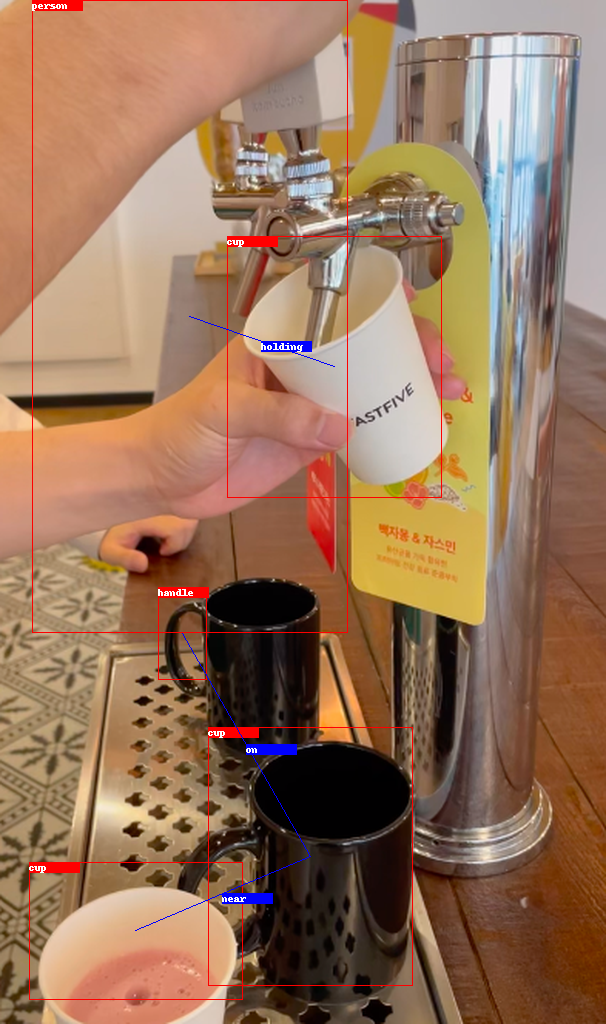

pred_labels 0: cup; score: 0.8912367224693298
pred_labels 1: cup; score: 0.748626708984375
pred_labels 2: person; score: 0.5424712300300598
pred_labels 3: handle; score: 0.5197486281394958
pred_labels 4: cup; score: 0.4704294800758362
**************************************************
pred_rels 32: 2 holding 0; score: 0.06675546616315842
pred_rels 606: 3 on 4; score: 7.141416426748037e-05
pred_rels 772: 1 near 4; score: 2.09481568163028e-05
pred_rels 923: 2 holding 4; score: 8.897396583051886e-06
pred_rels 1051: 4 has 3; score: 4.5770475480821915e-06
pred_rels 1081: 3 on 0; score: 4.1570901885279454e-06
pred_rels 1329: 0 has 3; score: 1.7372564116158173e-06
pred_rels 1498: 3 of 2; score: 1.1238792012591148e-06
pred_rels 1612: 2 has 3; score: 8.051086410887365e-07
pred_rels 1618: 3 on 1; score: 7.87222973031021e-07
pred_rels 1675: 4 near 1; score: 6.94767038567079e-07
pred_rels 1684: 1 has 3; score: 6.697727030768874e-07
pred_rels 1705: 2 holding 1; score: 6.395150080606982e-07
pred_rel

In [218]:
img_path = f'{data_dir}/drink.png'
res = detected_result["0"]

pred_scores = res["bbox_scores"][:5]
#pred_scores = [i for i in pred_scores if i > 1e-1]
pred_boxes = res["bbox"][:len(pred_scores)]
pred_labels = res["bbox_labels"][:len(pred_scores)]

pred_rel_score = res["rel_scores"]
#pred_rel_score = [i for i in pred_rel_score if i > 0]
pred_rels = res["rel_pairs"][:len(pred_rel_score)]
pred_rel_label = res["rel_labels"][:len(pred_rel_score)]

print(len(pred_scores), len(pred_rel_score))
draw_image(img_path=img_path, pred_boxes=pred_boxes, pred_labels=pred_labels, pred_scores=pred_scores, pred_rels=pred_rels, pred_rel_score=pred_rel_score, pred_rel_label=pred_rel_label)